In [15]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'keras-pretrained-models:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F2798%2F7251%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240311%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240311T165255Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D46becd7f1508840c82543d2ea7a3c711188176e7aadc3b7dfef196ecf0411553b210e24cf1a75e139e6c835a7faeee99d57b1984547c55dc1233066fb3a7e7e9fc74c3a55638b4b1b1adbfacc9f6fce98750ae4ed8544ea5f90f05b8b3d40ef5e18a46d1ac7ce46730d1c53480dd50ab4002621e1b87830fbd88734cc277689629a5975dbe3daed63e8481b2cab90f476c8fc46241887708b94ce856068fabf281644f1ceb724942502f5188928870c55c300786f8db2d382ff668aefa450c66c5e28548760af5f5a6fb0c7e3a9a59af87b343a0fb9b2783eeede14b7e722b5a6199a46529908692fb331b59118ac94646c89f9126d26703fd3b7a7974187e81,isic-2019:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F2711108%2F4677175%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240311%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240311T165255Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D6ade903c8949609f28ea6b15bab5a75e2cb23355bfbe7804838aa153b3a5f0c4e28cb4ce02a165e12abf0e4cce79ce89464751f0a3f18bcdb49003522fa075977981c2a72508c8c0b2fc74476c65cc653ce898726c4639968f495865173bc0573ff228127284448815c441c18f8f2064edf332765cb468fee83318122f5ad4ff07bb4c2de32c3743b89515c54af3a5866f4c5309055da3ef7fd1161b42fd4ec032b67b5606add4a188c66254f58540e9384c494e5c06c1555ff93f0221a2914ef05342042a97e9b5dc6c225d3541b654599dcb5a9a2e384b1be1ccfafce544e14f36bf205086fd8e11b25d3cd0c4e4e891a020604ce9aa7e6e6fdd3e8bf28e9c,isic-skin-disease-image-dataset-labelled:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F2803021%2F4837003%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240311%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240311T165255Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D8ef5b5d5e9576a39ed92082ed101874c06d4937cfb6f242c7fee2192f8e1bf102843aa7f453d3dfa5e47a0bd40ab79b5766cdbad0d8e7389f372459b86705d9f25a22d3edd52b1069c6b57bc71af056b5ce05acc5c5791c87738ea00435247565d1b5caf6f4b9100d71a69a0a60901b7902d07bd92332fed3f2344131d55a57cf36982e1c2a5c2b97197f08d7faf2739fa353ee8dbe62670da7fbaa1da058510a39e6e306def197f0923249a498cc4413b4ac8e92705bfda849c5fe972206020446ef4e097622509d320b48fb76ed458483b5c555d5315a86ed16eeb9135bc6394e271814cb3cefd516a16c835413abc1dbcc112d07d636f1e8c34f183d6665b'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 989248706 bytes downloaded
Downloaded and uncompressed: keras-pretrained-models
[==================================================] 9767139331 bytes downloaded
Downloaded and uncompressed: isic-2019
[==================================================] 9766946647 bytes downloaded
Downloaded and uncompressed: isic-skin-disease-image-dataset-labelled
Data source import complete.


In [16]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input/isic-skin-disease-image-dataset-labelled/ISIC_Labelled'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Streaming output truncated to the last 5000 lines.
/kaggle/input/isic-skin-disease-image-dataset-labelled/ISIC_Labelled/Melanocytic nevus/ISIC_0029436.jpg
/kaggle/input/isic-skin-disease-image-dataset-labelled/ISIC_Labelled/Melanocytic nevus/ISIC_0058761.jpg
/kaggle/input/isic-skin-disease-image-dataset-labelled/ISIC_Labelled/Melanocytic nevus/ISIC_0026764.jpg
/kaggle/input/isic-skin-disease-image-dataset-labelled/ISIC_Labelled/Melanocytic nevus/ISIC_0030336.jpg
/kaggle/input/isic-skin-disease-image-dataset-labelled/ISIC_Labelled/Melanocytic nevus/ISIC_0067474.jpg
/kaggle/input/isic-skin-disease-image-dataset-labelled/ISIC_Labelled/Melanocytic nevus/ISIC_0010574.jpg
/kaggle/input/isic-skin-disease-image-dataset-labelled/ISIC_Labelled/Melanocytic nevus/ISIC_0033188.jpg
/kaggle/input/isic-skin-disease-image-dataset-labelled/ISIC_Labelled/Melanocytic nevus/ISIC_0007475_downsampled.jpg
/kaggle/input/isic-skin-disease-image-dataset-labelled/ISIC_Labelled/Melanocytic nevus/ISIC_0025237.jpg
/

In [17]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_path = '/kaggle/input/isic-2019/ISIC - 2019/train/'
test_path = '/kaggle/input/isic-2019/ISIC - 2019/test/'



train_batches = ImageDataGenerator(validation_split=0.1) \
                .flow_from_directory(directory=train_path,
                                     classes = ['Actinic keratosis', 'Basal cell carcinoma',
                                                'Benign keratosis', 'Dermatofibroma','Melanocytic nevus', 'Melanoma' ,'Squamous cell carcinoma','Vascular lesion'],
                                     subset='training',
                                     batch_size=10)

validation_batches = ImageDataGenerator(validation_split=0.1) \
                     .flow_from_directory(directory=train_path,
                                          classes = ['Actinic keratosis', 'Basal cell carcinoma',
                                                'Benign keratosis', 'Dermatofibroma','Melanocytic nevus', 'Melanoma' ,'Squamous cell carcinoma','Vascular lesion'],
                                          subset='validation',
                                          batch_size=10)

test_batches = ImageDataGenerator() \
                    .flow_from_directory(directory=test_path,
                                        classes = ['Actinic keratosis', 'Basal cell carcinoma',
                                                'Benign keratosis', 'Dermatofibroma','Melanocytic nevus', 'Melanoma' ,'Squamous cell carcinoma','Vascular lesion'],
                                         batch_size=10,
                                         shuffle=False)

Found 19345 images belonging to 8 classes.
Found 2146 images belonging to 8 classes.
Found 1930 images belonging to 8 classes.


In [18]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import layers
import tensorflow.keras
from tensorflow.keras.utils import to_categorical, model_to_dot, plot_model
import tensorflow as tf
train_datagen = ImageDataGenerator(
    rescale= 1./255,
    zoom_range= (0.73, 0.9),
    horizontal_flip= True,
    rotation_range= 10,
    width_shift_range= 0.10,
    fill_mode= 'constant',
    height_shift_range= 0.10,
    brightness_range= (0.55, 0.9),
)

valid_test_datagen = ImageDataGenerator(
    rescale= 1./255,
)

In [19]:
IMG_SIZE = 128
n_classes = 8

inp = layers.Input(shape=(IMG_SIZE,IMG_SIZE,3))
x1 = layers.Resizing(IMG_SIZE, IMG_SIZE)(inp)
x2 = layers.Rescaling(1./255)(x1)
x3 = layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu',
                   padding = 'same', input_shape=(IMG_SIZE,IMG_SIZE,3))(x2)
x5 = layers.BatchNormalization(axis=-1)(x3)
x6 = layers.MaxPool2D(pool_size=(2, 2))(x5)
x7 = layers.Conv2D(filters=64, kernel_size=(3, 3),
                   activation='relu', padding = 'same')(x6)
x9 = layers.BatchNormalization(axis=-1)(x7)
x10 = layers.MaxPool2D(pool_size=(2, 2))(x9)

x11 = layers.Conv2D(filters=128, kernel_size=(3, 3),
                    activation='relu', padding = 'same')(x10)
x13 = layers.BatchNormalization(axis=-1)(x11)
x14 = layers.MaxPool2D(pool_size=(2, 2))(x13)
x15 = layers.Conv2D(filters=256, kernel_size=(3, 3),
                      activation='relu', padding = 'same')(x14)
x17 = layers.BatchNormalization(axis=-1)(x15)
x18 = layers.MaxPool2D(pool_size=(2, 2))(x17)
y1 = layers.Flatten()(x18)
y2 = layers.Dense(300, activation='relu')(y1)
y3 = layers.Dense(150, activation='relu')(y2)
y4 = layers.Dropout(0.25)(y3)
y = layers.Dense(n_classes, activation='softmax')(y4)

model = tensorflow.keras.Model(inp,y)

In [20]:
EPOCHS = 20
BATCH_SIZE = 8
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                  loss='categorical_crossentropy',
                  metrics='accuracy')
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 resizing_2 (Resizing)       (None, 128, 128, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 128, 128, 3)       0         
                                                                 
 conv2d_8 (Conv2D)           (None, 128, 128, 32)      896       
                                                                 
 batch_normalization_8 (Bat  (None, 128, 128, 32)      128       
 chNormalization)                                                
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 64, 64, 32)        0         
 g2D)                                                      

In [21]:
history = model.fit(x=train_batches,
                            validation_data=validation_batches,
                            steps_per_epoch=len(train_batches),
                            validation_steps=len(validation_batches),
                            epochs=20,
                            batch_size=BATCH_SIZE,
                            verbose=1)

Epoch 1/20
1935/1935 [==============================] - 295s 148ms/step - loss: 1.2793 - accuracy: 0.5642 - val_loss: 1.5092 - val_accuracy: 0.5014
Epoch 2/20
1935/1935 [==============================] - 279s 144ms/step - loss: 1.0991 - accuracy: 0.6135 - val_loss: 1.4695 - val_accuracy: 0.4692
Epoch 3/20
1935/1935 [==============================] - 269s 139ms/step - loss: 1.0269 - accuracy: 0.6389 - val_loss: 1.6164 - val_accuracy: 0.5000
Epoch 4/20
1935/1935 [==============================] - 263s 136ms/step - loss: 0.9664 - accuracy: 0.6594 - val_loss: 1.4227 - val_accuracy: 0.4935
Epoch 5/20
1935/1935 [==============================] - 266s 138ms/step - loss: 0.9005 - accuracy: 0.6802 - val_loss: 1.4249 - val_accuracy: 0.4781
Epoch 6/20
1935/1935 [==============================] - 258s 133ms/step - loss: 0.8408 - accuracy: 0.7011 - val_loss: 1.3841 - val_accuracy: 0.5391
Epoch 7/20
1935/1935 [==============================] - 253s 131ms/step - loss: 0.7663 - accuracy: 0.7299 - val_

193/193 [==============================] - 23s 118ms/step


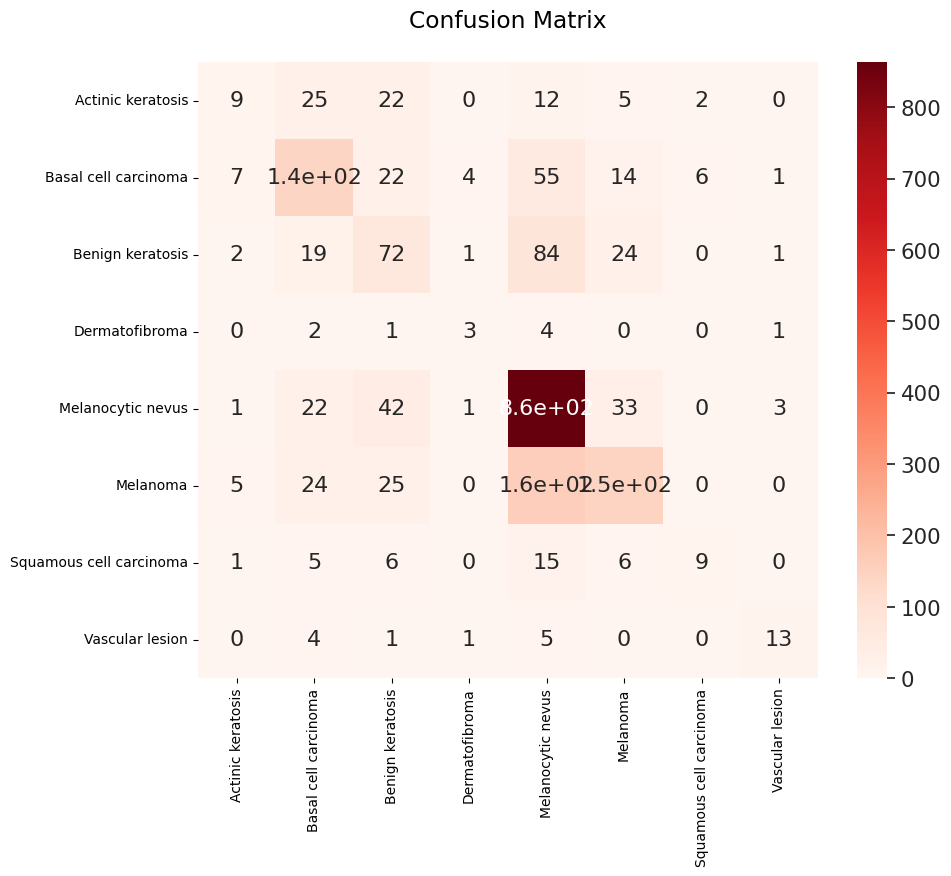

Classification Report

                         precision    recall  f1-score   support

      Actinic keratosis       0.36      0.12      0.18        75
   Basal cell carcinoma       0.58      0.56      0.57       250
       Benign keratosis       0.38      0.35      0.37       203
         Dermatofibroma       0.30      0.27      0.29        11
      Melanocytic nevus       0.72      0.89      0.80       965
               Melanoma       0.64      0.41      0.50       360
Squamous cell carcinoma       0.53      0.21      0.31        42
        Vascular lesion       0.68      0.54      0.60        24

               accuracy                           0.65      1930
              macro avg       0.52      0.42      0.45      1930
           weighted avg       0.63      0.65      0.63      1930



In [22]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sn
num_classes = len(train_batches.class_indices)
train_labels = train_batches.classes
train_labels = to_categorical(train_labels, num_classes=num_classes)
valid_labels = validation_batches.classes
valid_labels = to_categorical(valid_labels, num_classes=num_classes)
nb_train_samples = len(train_batches.filenames)
nb_valid_samples = len(validation_batches.filenames)
nb_test_samples = len(test_batches.filenames)
Y_pred = model.predict(test_batches, nb_test_samples // BATCH_SIZE+1)
y_pred = np.argmax(Y_pred, axis=1)
cm = confusion_matrix(test_batches.classes, y_pred)
df_cm = pd.DataFrame(cm, list(test_batches.class_indices.keys()), list(test_batches.class_indices.keys()))
fig, ax = plt.subplots(figsize=(10,8))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, cmap=plt.cm.Reds)
plt.title('Confusion Matrix\n')
plt.savefig('confusion_matrix.png', transparent= False, bbox_inches= 'tight', dpi= 400)
plt.show()

print('Classification Report\n')
target_names = list(test_batches.class_indices.keys())
print(classification_report(test_batches.classes, y_pred, target_names=target_names))

In [23]:
model.save('skinclassifier1.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [24]:
from keras import backend as K
from keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D, Reshape, Dense, multiply, Permute, Concatenate, Conv2D, Add, Activation, Lambda

def cbam_block(cbam_feature, ratio=8):
    """Contains the implementation of Convolutional Block Attention Module(CBAM) block.
    As described in https://arxiv.org/abs/1807.06521.
    """

    cbam_feature = channel_attention(cbam_feature, ratio)
    cbam_feature = spatial_attention(cbam_feature)
    return cbam_feature

def channel_attention(input_feature, ratio=8):

    channel_axis = 1 if K.image_data_format() == "channels_first" else -1
    channel = input_feature.shape[channel_axis]

    shared_layer_one = Dense(channel//ratio,
                             activation='relu',
                             kernel_initializer='he_normal',
                             use_bias=True,
                             bias_initializer='zeros')
    shared_layer_two = Dense(channel,
                             kernel_initializer='he_normal',
                             use_bias=True,
                             bias_initializer='zeros')

    avg_pool = GlobalAveragePooling2D()(input_feature)
    avg_pool = Reshape((1,1,channel))(avg_pool)
    assert avg_pool.shape[1:] == (1,1,channel)
    avg_pool = shared_layer_one(avg_pool)
    assert avg_pool.shape[1:] == (1,1,channel//ratio)
    avg_pool = shared_layer_two(avg_pool)
    assert avg_pool.shape[1:] == (1,1,channel)

    max_pool = GlobalMaxPooling2D()(input_feature)
    max_pool = Reshape((1,1,channel))(max_pool)
    assert max_pool.shape[1:] == (1,1,channel)
    max_pool = shared_layer_one(max_pool)
    assert max_pool.shape[1:] == (1,1,channel//ratio)
    max_pool = shared_layer_two(max_pool)
    assert max_pool.shape[1:] == (1,1,channel)

    cbam_feature = Add()([avg_pool,max_pool])
    cbam_feature = Activation('sigmoid')(cbam_feature)

    if K.image_data_format() == "channels_first":
        cbam_feature = Permute((3, 1, 2))(cbam_feature)

    return multiply([input_feature, cbam_feature])

def spatial_attention(input_feature):
    kernel_size = 7

    if K.image_data_format() == "channels_first":
        channel = input_feature.shape[1]
        cbam_feature = Permute((2,3,1))(input_feature)
    else:
        channel = input_feature.shape[-1]
        cbam_feature = input_feature

    avg_pool = Lambda(lambda x: K.mean(x, axis=3, keepdims=True))(cbam_feature)
    assert avg_pool.shape[-1] == 1
    max_pool = Lambda(lambda x: K.max(x, axis=3, keepdims=True))(cbam_feature)
    assert max_pool.shape[-1] == 1
    concat = Concatenate(axis=3)([avg_pool, max_pool])
    assert concat.shape[-1] == 2
    cbam_feature = Conv2D(filters = 1,
                    kernel_size=kernel_size,
                    strides=1,
                    padding='same',
                    activation='sigmoid',
                    kernel_initializer='he_normal',
                    use_bias=False)(concat)
    assert cbam_feature.shape[-1] == 1

    if K.image_data_format() == "channels_first":
        cbam_feature = Permute((3, 1, 2))(cbam_feature)

    return multiply([input_feature, cbam_feature])

In [25]:
IMG_SIZE = 224
n_classes = 8

inp = layers.Input(shape=(IMG_SIZE,IMG_SIZE,3))
x1 = layers.Resizing(IMG_SIZE, IMG_SIZE)(inp)
x2 = layers.Rescaling(1./255)(x1)
x3 = layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu',
                   padding = 'same', input_shape=(IMG_SIZE,IMG_SIZE,3))(x2)
x4 = cbam_block(x3)
x5 = layers.BatchNormalization(axis=-1)(x4)
x6 = layers.MaxPool2D(pool_size=(2, 2))(x5)
x7 = layers.Conv2D(filters=64, kernel_size=(3, 3),
                   activation='relu', padding = 'same')(x6)
x8 = cbam_block(x7)
x9 = layers.BatchNormalization(axis=-1)(x8)
x10 = layers.MaxPool2D(pool_size=(2, 2))(x9)
x11 = layers.Conv2D(filters=128, kernel_size=(3, 3),
                    activation='relu', padding = 'same')(x10)
x12 = cbam_block(x11)
x13 = layers.BatchNormalization(axis=-1)(x12)
x14 = layers.MaxPool2D(pool_size=(2, 2))(x13)
x15 = layers.Conv2D(filters=256, kernel_size=(3, 3),
                      activation='relu', padding = 'same')(x14)
x16 = cbam_block(x15)
x17 = layers.BatchNormalization(axis=-1)(x16)
x18 = layers.MaxPool2D(pool_size=(2, 2))(x17)
y1 = layers.Flatten()(x18)
y2 = layers.Dense(300, activation='relu')(y1)
y3 = layers.Dense(150, activation='relu')(y2)
y4 = layers.Dropout(0.25)(y3)
y = layers.Dense(n_classes, activation='softmax')(y4)


model_CBAM = tf.keras.Model(inp, y)
model_CBAM.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                   loss='categorical_crossentropy',
                   metrics='accuracy')
model_CBAM.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 resizing_3 (Resizing)       (None, 224, 224, 3)          0         ['input_4[0][0]']             
                                                                                                  
 rescaling_3 (Rescaling)     (None, 224, 224, 3)          0         ['resizing_3[0][0]']          
                                                                                                  
 conv2d_12 (Conv2D)          (None, 224, 224, 32)         896       ['rescaling_3[0][0]']         
                                                                                            

In [ ]:
history_CBAM = model_CBAM.fit(x=train_batches,
                              validation_data=validation_batches,
                              steps_per_epoch=len(train_batches),
                              validation_steps=len(validation_batches),
                              epochs=20,
                              batch_size=BATCH_SIZE,
                              verbose=1)

Epoch 1/20
1935/1935 [==============================] - 340s 170ms/step - loss: 1.2521 - accuracy: 0.5628 - val_loss: 1.3641 - val_accuracy: 0.5051
Epoch 2/20
1935/1935 [==============================] - 305s 158ms/step - loss: 1.0862 - accuracy: 0.6187 - val_loss: 1.4017 - val_accuracy: 0.5182
Epoch 3/20
1935/1935 [==============================] - 308s 159ms/step - loss: 1.0209 - accuracy: 0.6385 - val_loss: 1.6390 - val_accuracy: 0.5103
Epoch 4/20
1935/1935 [==============================] - 313s 162ms/step - loss: 0.9404 - accuracy: 0.6680 - val_loss: 1.3805 - val_accuracy: 0.5186
Epoch 5/20
1935/1935 [==============================] - 307s 159ms/step - loss: 0.8890 - accuracy: 0.6836 - val_loss: 1.7444 - val_accuracy: 0.5363
Epoch 6/20
1935/1935 [==============================] - 312s 161ms/step - loss: 0.8221 - accuracy: 0.7066 - val_loss: 1.4710 - val_accuracy: 0.5429
Epoch 7/20
1935/1935 [==============================] - 312s 161ms/step - loss: 0.7473 - accuracy: 0.7305 - val_

In [ ]:
img_path = '/kaggle/input/isic-2019/ISIC - 2019/test/Basal cell carcinoma/ISIC_0024461.jpg'

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sn
num_classes = len(train_batches.class_indices)
train_labels = train_batches.classes
train_labels = to_categorical(train_labels, num_classes=num_classes)
valid_labels = validation_batches.classes
valid_labels = to_categorical(valid_labels, num_classes=num_classes)
nb_train_samples = len(train_batches.filenames)
nb_valid_samples = len(validation_batches.filenames)
nb_test_samples = len(test_batches.filenames)
Y_pred = model_CBAM.predict(test_batches, nb_test_samples // BATCH_SIZE+1)
y_pred = np.argmax(Y_pred, axis=1)
cm = confusion_matrix(test_batches.classes, y_pred)
df_cm = pd.DataFrame(cm, list(test_batches.class_indices.keys()), list(test_batches.class_indices.keys()))
fig, ax = plt.subplots(figsize=(10,8))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, cmap=plt.cm.Reds)
plt.title('Confusion Matrix\n')
plt.savefig('confusion_matrix.png', transparent= False, bbox_inches= 'tight', dpi= 400)
plt.show()

print('Classification Report\n')
target_names = list(test_batches.class_indices.keys())
print(classification_report(test_batches.classes, y_pred, target_names=target_names))

In [ ]:
model_CBAM.save('skinclassifier1.h5')